In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

## EDA

In [2]:
df = pd.read_csv('ARTHUR_Queue_Times_By_Date_Time.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'ARTHUR_WaitTime', 'Month', 'Year', 'Date', 'Time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh'],
      dtype='object')

In [4]:
df = df.drop(columns=['Unnamed: 0'])


In [5]:
df.columns

Index(['ARTHUR_WaitTime', 'Month', 'Year', 'Date', 'Time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh'],
      dtype='object')

In [6]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [7]:
# Sort by DateTime to ensure proper time series order
df = df.sort_values(by='DateTime').reset_index(drop=True)

In [ ]:
wait_time_cols = [col for col in df.columns if '_WaitTime' in col]
# Target variable for EDA
TARGET = 'ARTHUR_WaitTime'

In [19]:
# Handling Special Wait Time Values based on Legend
# Create new feature columns for each attraction status based on the legend
df['status_open'] = (df[TARGET] == 0).astype(int)
df['status_virtual_queue'] = (df[TARGET] == -1).astype(int)
df['status_maintenance'] = (df[TARGET] == -2).astype(int)
df['status_closed_weather'] = (df[TARGET] == -3).astype(int)
df['status_attraction_closed'] = (df[TARGET] == -4).astype(int)
df['status_over_90_min'] = (df[TARGET] == 91).astype(int)

In [22]:
# Replace negative values with NaN in the target column to be imputed
df.loc[df[TARGET] < 0, TARGET] = np.nan

# Impute the created NaNs using forward-fill and then backward-fill
df[TARGET] = df[TARGET].ffill().bfill()

In [23]:
# Set a style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

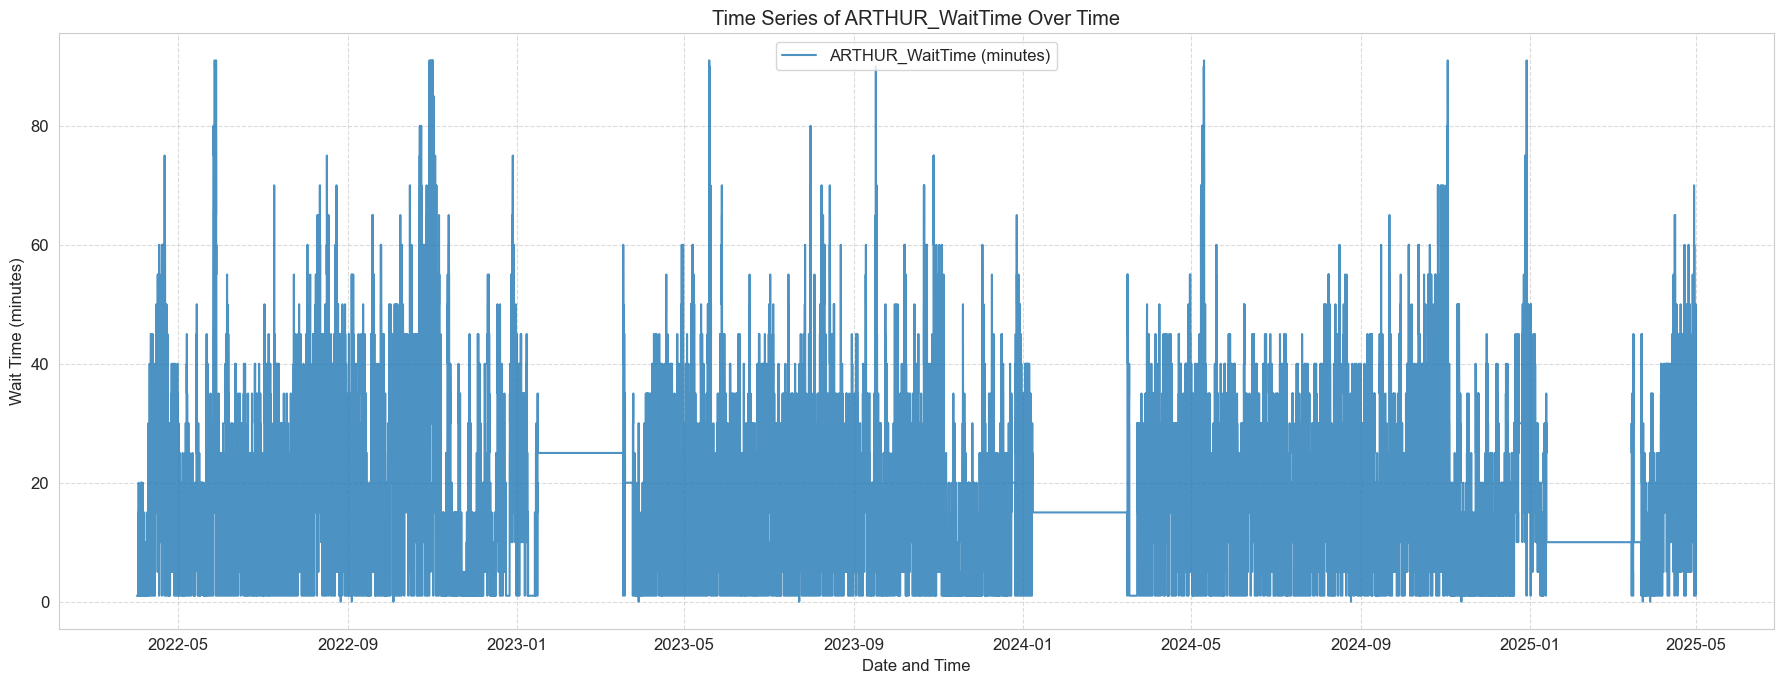

In [24]:


# Plot 1: Time Series Plot of ARTHUR_WaitTime
plt.figure(figsize=(18, 7))
plt.plot(df['DateTime'], df[TARGET], label=f'{TARGET} (minutes)', alpha=0.8)
plt.title(f'Time Series of {TARGET} Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


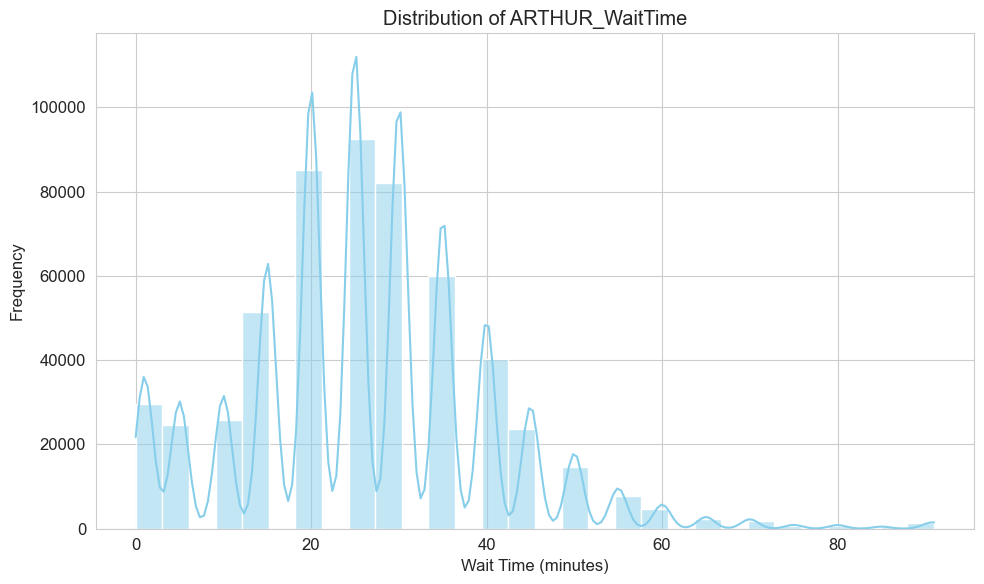

In [25]:
# Plot 2: Distribution of ARTHUR_WaitTime
plt.figure(figsize=(10, 6))
sns.histplot(df[TARGET].dropna(), kde=True, bins=30, color='skyblue')
plt.title(f'Distribution of {TARGET}')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

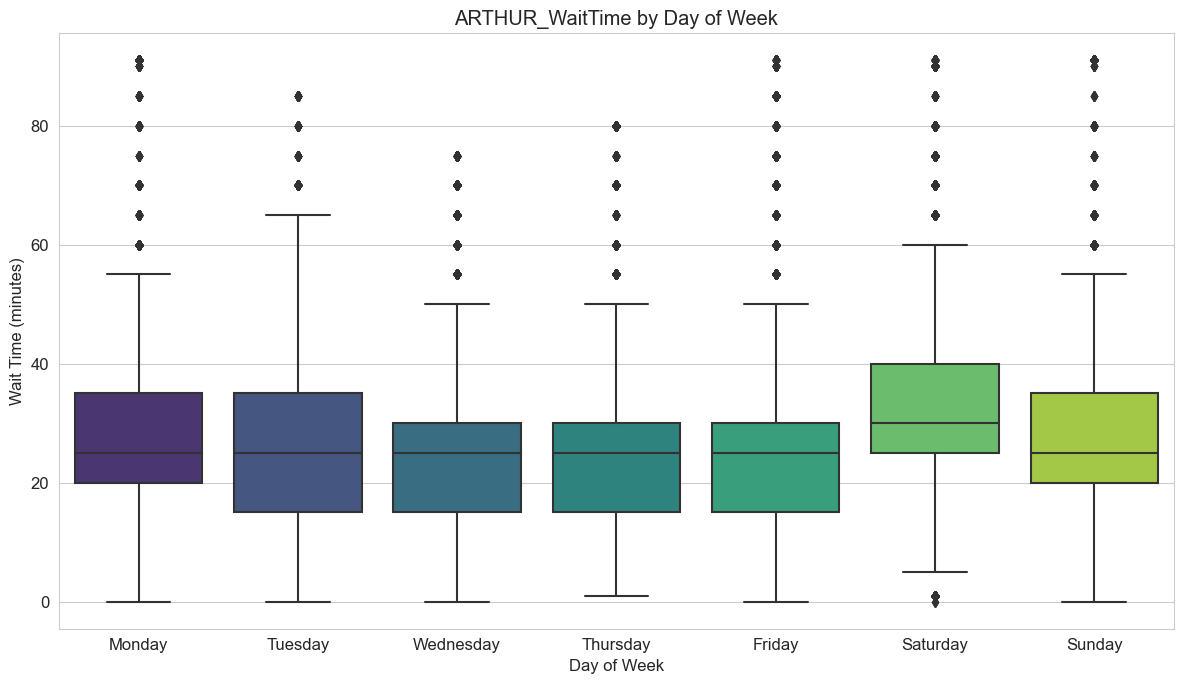

In [26]:
# Plot 3: Box Plot of ARTHUR_WaitTime by Day of Week
# Add day of week and hour of day features for plotting
df['day_of_week'] = df['DateTime'].dt.day_name()
df['hour_of_day'] = df['DateTime'].dt.hour

plt.figure(figsize=(12, 7))
sns.boxplot(x='day_of_week', y=TARGET, data=df, palette='viridis',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title(f'{TARGET} by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Wait Time (minutes)')
plt.tight_layout()
plt.show()

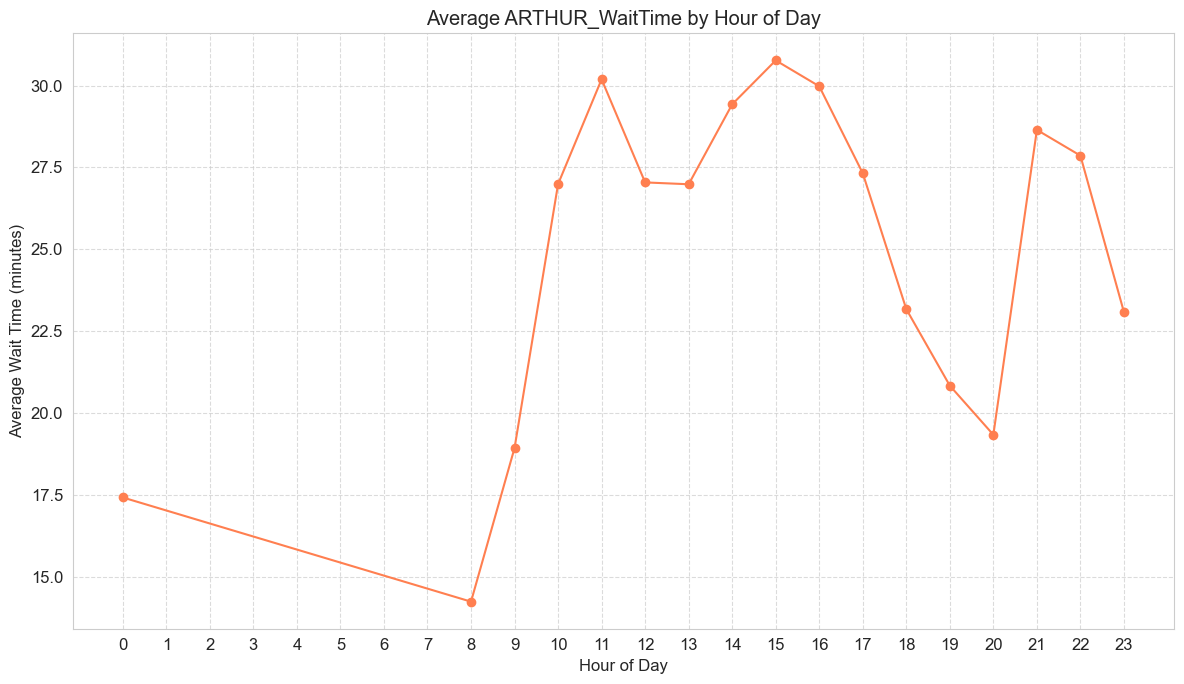

In [27]:
# Plot 4: Line Plot of Average ARTHUR_WaitTime by Hour of Day
plt.figure(figsize=(12, 7))
df.groupby('hour_of_day')[TARGET].mean().plot(kind='line', marker='o', color='coral')
plt.title(f'Average {TARGET} by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Wait Time (minutes)')
plt.xticks(range(24)) # Ensure all hours are displayed
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


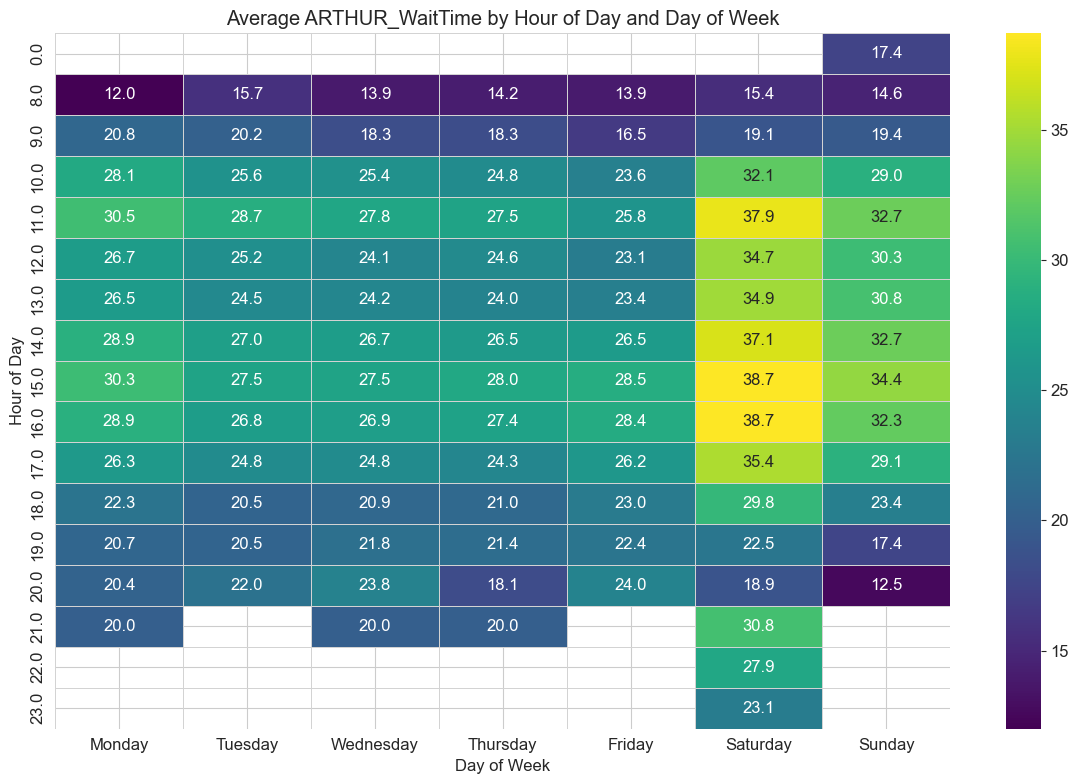

In [28]:
# Plot 5: Heatmap of Average Wait Times for multiple attractions by Hour and Day of Week
# Select a few key attractions for this heatmap
selected_attractions = [
    'ARTHUR_WaitTime'
]

# Create average wait times pivot table
df_hourly_daily_avg = df.groupby(['day_of_week', 'hour_of_day'])[selected_attractions].mean().reset_index()

# Reorder days for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_hourly_daily_avg['day_of_week'] = pd.Categorical(df_hourly_daily_avg['day_of_week'], categories=day_order, ordered=True)
df_hourly_daily_avg = df_hourly_daily_avg.sort_values(['day_of_week', 'hour_of_day'])

# Plot individual heatmaps for each selected attraction
for col in selected_attractions:
    pivot_table = df_hourly_daily_avg.pivot_table(index='hour_of_day', columns='day_of_week', values=col)
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1f", linewidths=.5, linecolor='lightgray')
    plt.title(f'Average {col} by Hour of Day and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.tight_layout()
    plt.show()


## Time Series forecasting  with RandomForestRegressor on Arthur_waitingtimes

In [29]:
# Phase 1: Data Preparation and Feature Engineering

# 1. Generate Lag Features for Target
LAG_SIZE = 5
for i in range(1, LAG_SIZE + 1):
    df[f'{TARGET}_lag{i}'] = df[TARGET].shift(i)

# Remove rows with NaN values resulting from lagging
df = df.dropna().reset_index(drop=True)

# 2. Extract Time-Based Features
df['hour_of_day'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = (df['DateTime'].dt.dayofweek >= 5).astype(int)
df['minute_of_hour'] = df['DateTime'].dt.minute

In [30]:

# 3. Define Features (X) and Labels (y)
lag_features = [f'{TARGET}_lag{i}' for i in range(1, LAG_SIZE + 1)]
time_features = ['hour_of_day', 'day_of_week', 'day_of_year', 'month', 'is_weekend', 'minute_of_hour']
status_features = ['status_open', 'status_virtual_queue', 'status_maintenance', 'status_closed_weather', 'status_attraction_closed', 'status_over_90_min']

In [31]:

# Combine all features for the model
features = lag_features + time_features + status_features
X = df[features]
y = df[TARGET]

In [34]:
# Phase 2: Model Training and Prediction

# 1. Data Splitting (Time Series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=False
)
# 2. Model Initialization
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 3. Model Training
model.fit(X_train, y_train)

# 4. Prediction
y_pred = model.predict(X_test)

In [35]:

# Phase 3: Model Evaluation and Baseline Comparison

# 1. Model Performance Metric
mae_model = mean_absolute_error(y_test, y_pred)
print(f"Model Mean Absolute Error (MAE): {mae_model:.4f}")

Model Mean Absolute Error (MAE): 0.7031


In [36]:

# 2. Persistence Baseline
y_baseline = X_test[f'{TARGET}_lag1']
mae_baseline = mean_absolute_error(y_test, y_baseline)
print(f"Persistence Baseline Mean Absolute Error (MAE): {mae_baseline:.4f}")

Persistence Baseline Mean Absolute Error (MAE): 0.2226


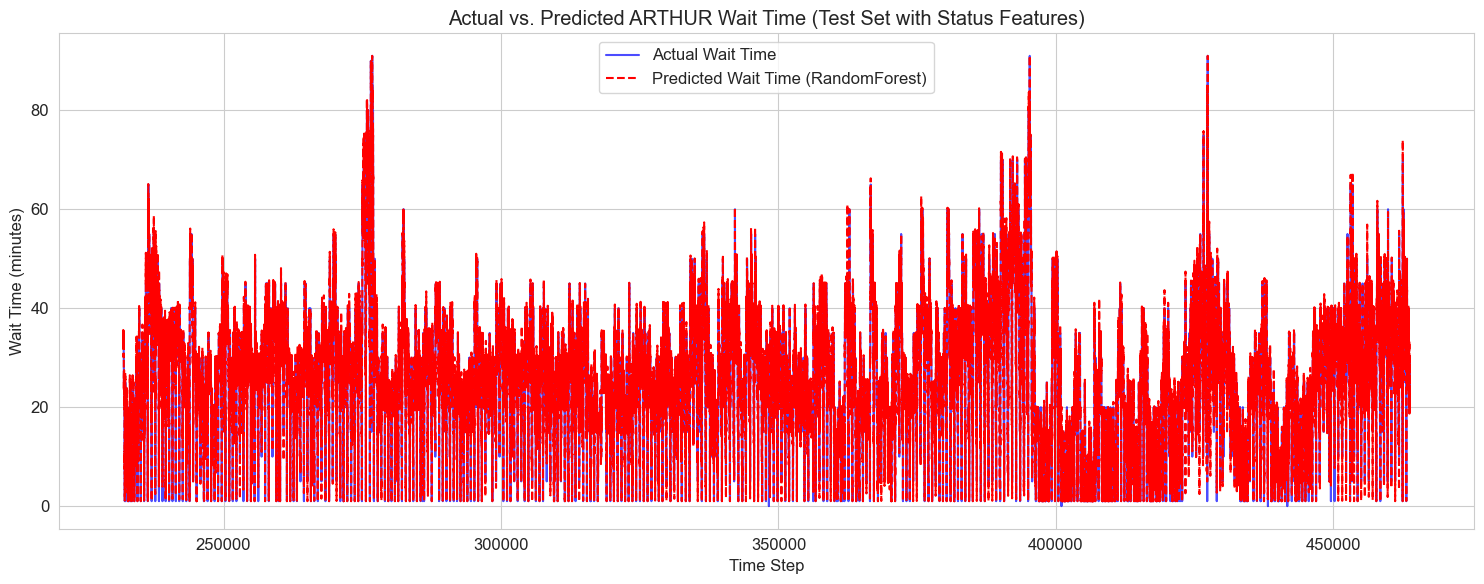

In [37]:
# 4. Visualizations

# Plot Actual vs. Predicted Wait Times
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Wait Time', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted Wait Time (RandomForest)', color='red', linestyle='--')
plt.title('Actual vs. Predicted ARTHUR Wait Time (Test Set with Status Features)')
plt.xlabel('Time Step')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_vs_predicted_with_status.png')
plt.show()

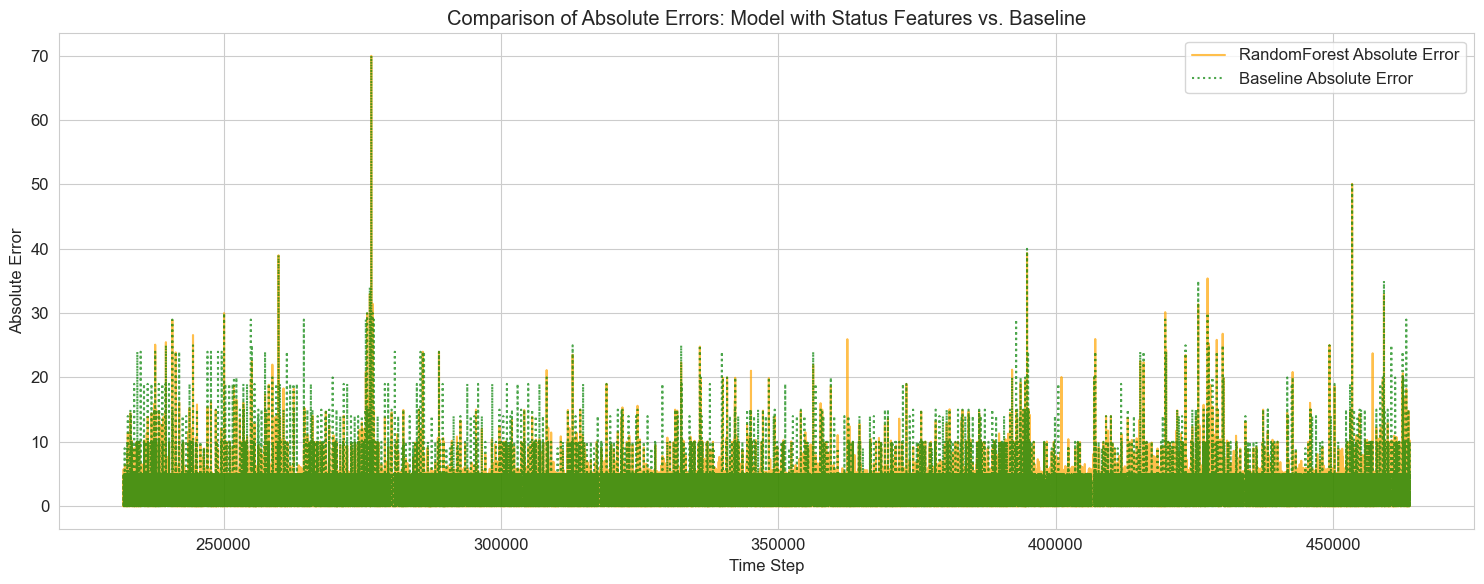

In [38]:

# Plot Absolute Errors of Model vs. Baseline
model_errors = abs(y_test - y_pred)
baseline_errors = abs(y_test - y_baseline)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, model_errors, label='RandomForest Absolute Error', color='orange', alpha=0.7)
plt.plot(y_test.index, baseline_errors, label='Baseline Absolute Error', color='green', alpha=0.7, linestyle=':')
plt.title('Comparison of Absolute Errors: Model with Status Features vs. Baseline')
plt.xlabel('Time Step')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('error_comparison_with_status.png')
plt.show()

using weather features to see performance difference

In [39]:
weather_features = ['temperature_in_celsius', 'precipitation_in_percent', 'wind_speed_in_kmh']
df[weather_features] = df[weather_features].ffill().bfill()

In [40]:
features = lag_features + time_features + status_features + weather_features

# 1. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=False
)

# 2. Model Initialization and Training
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 3. Prediction
y_pred = model.predict(X_test)

# Phase 3: Model Evaluation and Baseline Comparison

# 1. Model Performance
mae_model = mean_absolute_error(y_test, y_pred)
print(f"Model with Weather Features MAE: {mae_model:.4f}")

# 2. Persistence Baseline
y_baseline = X_test[f'{TARGET}_lag1']
mae_baseline = mean_absolute_error(y_test, y_baseline)
print(f"Persistence Baseline MAE: {mae_baseline:.4f}")

Model with Weather Features MAE: 0.7031
Persistence Baseline MAE: 0.2226


### --- Part 2: Advanced Feature Engineering ---

In [41]:
print("Starting Advanced Feature Engineering...")

# 1. Interaction Features
df['temp_x_weekend'] = df['temperature_in_celsius'] * df['is_weekend']
df['precip_x_weekend'] = df['precipitation_in_percent'] * df['is_weekend']

# 2. Rolling Average Features
# Calculate rolling means over different windows
df['rolling_mean_15min'] = df[TARGET].rolling(window=3, min_periods=1).mean() # 3 * 5 mins
df['rolling_mean_30min'] = df[TARGET].rolling(window=6, min_periods=1).mean()
df['rolling_mean_1hr'] = df[TARGET].rolling(window=12, min_periods=1).mean()

Starting Advanced Feature Engineering...


In [43]:
RANDOM_STATE = 42


def train_and_evaluate(df, forecast_horizon_minutes=5):
    """
    A function to handle feature creation, model training, and evaluation for a given forecast horizon.
    """
    print(f"\n--- Training models for a {forecast_horizon_minutes}-minute forecast horizon ---")

    # Adjust target for the forecast horizon
    # `shift(-n)` pulls future values `n` steps back, aligning them with current features.
    df['target_shifted'] = df[TARGET].shift(-int(forecast_horizon_minutes / 5)) # Assuming 5-min intervals
    
    # Drop rows where the shifted target is NaN (i.e., the last few rows of the dataset)
    df_model = df.dropna(subset=['target_shifted']).copy()

    # Define all features
    lag_features = [f'{TARGET}_lag{i}' for i in range(1, 6)]
    time_features = ['hour_of_day', 'day_of_week', 'day_of_year', 'month', 'is_weekend', 'minute_of_hour']
    status_features = ['status_open', 'status_virtual_queue', 'status_maintenance', 'status_closed_weather', 'status_attraction_closed', 'status_over_90_min']
    interaction_features = ['temp_x_weekend', 'precip_x_weekend']
    rolling_features = ['rolling_mean_15min', 'rolling_mean_30min', 'rolling_mean_1hr']
    
    # Generate base features (must be done *after* shifting for rolling means to be correct)
    df_model['hour_of_day'] = df_model['DateTime'].dt.hour
    df_model['day_of_week'] = df_model['DateTime'].dt.dayofweek
    df_model['day_of_year'] = df_model['DateTime'].dt.dayofyear
    df_model['month'] = df_model['DateTime'].dt.month
    df_model['is_weekend'] = (df_model['DateTime'].dt.dayofweek >= 5).astype(int)
    df_model['minute_of_hour'] = df_model['DateTime'].dt.minute

    for i in range(1, 6):
        df_model[f'{TARGET}_lag{i}'] = df_model[TARGET].shift(i)
    
    df_model = df_model.dropna() # Drop NaNs created by lags

    # Combine all features for the model
    features = lag_features + time_features + status_features + weather_features + interaction_features + rolling_features
    X = df_model[features]
    y = df_model['target_shifted']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

    # --- Initialize Models ---
    models = {
        'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        'XGBoost': XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        'LightGBM': LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    }

    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = mae
        print(f"{name} MAE: {mae:.4f}")

    # Baseline
    # The baseline must also predict `forecast_horizon_minutes` ahead.
    # The best naive predictor is the current value, so we use lag1.
    y_baseline = X_test[f'{TARGET}_lag1']
    mae_baseline = mean_absolute_error(y_test, y_baseline)
    results['Baseline'] = mae_baseline
    print(f"Persistence Baseline MAE: {mae_baseline:.4f}")
    
    return results

In [44]:
# --- Run Experiments ---
results_5_min = train_and_evaluate(df.copy(), forecast_horizon_minutes=5)
results_30_min = train_and_evaluate(df.copy(), forecast_horizon_minutes=30)
results_60_min = train_and_evaluate(df.copy(), forecast_horizon_minutes=60)


--- Training models for a 5-minute forecast horizon ---
Training RandomForest...
RandomForest MAE: 0.7764
Training XGBoost...
XGBoost MAE: 0.4075
Training LightGBM...
LightGBM MAE: 0.3472
Persistence Baseline MAE: 0.4418

--- Training models for a 30-minute forecast horizon ---
Training RandomForest...
RandomForest MAE: 2.2131
Training XGBoost...
XGBoost MAE: 1.8566
Training LightGBM...
LightGBM MAE: 1.5885
Persistence Baseline MAE: 1.4756

--- Training models for a 60-minute forecast horizon ---
Training RandomForest...
RandomForest MAE: 3.2981
Training XGBoost...
XGBoost MAE: 2.8892
Training LightGBM...
LightGBM MAE: 2.6336
Persistence Baseline MAE: 2.5420


In [47]:
# --- Part 4: Hyperparameter Tuning for the Best Model ---
print("\n--- Hyperparameter Tuning for LightGBM (60-minute horizon) ---")

# Let's tune LightGBM for the 60-min forecast as it's the most challenging
df_60_min = df.copy()
df_60_min['target_shifted'] = df_60_min[TARGET].shift(-12)
df_60_min = df_60_min.dropna(subset=['target_shifted'])
# Recreate features for the tuning dataset
df_60_min['hour_of_day'] = df_60_min['DateTime'].dt.hour
df_60_min['day_of_week'] = df_60_min['DateTime'].dt.dayofweek
df_60_min['is_weekend'] = (df_60_min['DateTime'].dt.dayofweek >= 5).astype(int)
for i in range(1, 6):
    df_60_min[f'{TARGET}_lag{i}'] = df_60_min[TARGET].shift(i)
df_60_min = df_60_min.dropna()
df_60_min = df_60_min.drop(columns="Month")

features = [col for col in df_60_min.columns if col not in ['Date', 'Time', 'DateTime', TARGET, 'target_shifted']]
X_tune = df_60_min[features]
y_tune = df_60_min['target_shifted']

X_train_tune, X_test_tune, y_train_tune, y_test_tune = train_test_split(X_tune, y_tune, test_size=0.5, shuffle=False)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)

# Randomized search with 3-fold cross-validation
# n_iter controls how many parameter combinations are tried.
random_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1, random_state=RANDOM_STATE
)
print("Running Randomized Search...")
random_search.fit(X_train_tune, y_train_tune)

print("Best Parameters found: ", random_search.best_params_)
best_lgbm = random_search.best_estimator_
y_pred_tuned = best_lgbm.predict(X_test_tune)
mae_tuned = mean_absolute_error(y_test_tune, y_pred_tuned)

print(f"Tuned LightGBM MAE (60-min horizon): {mae_tuned:.4f}")
print(f"Untuned LightGBM MAE (60-min horizon): {results_60_min['LightGBM']:.4f}")


--- Hyperparameter Tuning for LightGBM (60-minute horizon) ---
Running Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters found:  {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}
Tuned LightGBM MAE (60-min horizon): 2.6093
Untuned LightGBM MAE (60-min horizon): 2.6336
